# Cyclum on PC3 Dataset

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt

import numpy as np

import cyclum.tuning

cell_line = "PC3"

Using TensorFlow backend.


## Get Data

In [3]:
raw_Y = pd.read_pickle('../../data/McDavid/pc3_df.pkl').T

cpt = pd.read_pickle('../../data/McDavid/pc3_cpt.pkl').values
print("Original dimesion %d cells x %d genes." % raw_Y.shape)
print(f"G0/G1 {sum(cpt == 'g0/g1')}, S {sum(cpt == 's')}, G2/M {sum(cpt == 'g2/m')}")

Y = preprocessing.scale(raw_Y)

N, D = Y.shape
print('After filtering %d Cells (instances) x %d Genes (features)'%(N, D))

Original dimesion 361 cells x 253 genes.
G0/G1 [85], S [141], G2/M [135]
After filtering 361 Cells (instances) x 253 Genes (features)


## Auto Tuning

In [4]:
model = cyclum.tuning.CyclumAutoTune(Y, max_linear_dims=3, 
                                     epochs=1000, rate=5e-4, verbose=100,
                                     encoder_width=[30, 20])


Auto tuning number of linear components...
Performing PCA...
Training Autoencoder with...
    0 linear dimensions...




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


epoch: 100/1000, loss:  0.7312, time elapsed:  5.64s, time left:  50.77s
epoch: 200/1000, loss:  0.6752, time elapsed:  9.92s, time left:  39.70s
epoch: 300/1000, loss:  0.6677, time elapsed:  14.04s, time left:  32.76s
epoch: 400/1000, loss:  0.6598, time elapsed:  18.30s, time left:  27.46s
epoch: 500/1000, loss:  0.6553, time elapsed:  22.54s, time left:  22.54s
epoch: 600/1000, loss:  0.6553, time elapsed:  26.75s, time left:  17.83s
epoch: 700/1000, loss:  0.6512, time elapsed:  30.96s, time left:  13.27s
epoch: 800/1000, loss:  0.6531, time elapsed:  35.22s, time left:  8.80s
epoch: 900/1000, loss:  0.6480, time elapsed:  39.43s, time left:  4.38s
epoch: 1000/1000, loss:  0.6462, time elapsed:  43.58s, time left:  0.00s
[0.6461728943351893]
[0.64

It seems that $k=2$, i.e., $1$ linear dimensions is a good choice.

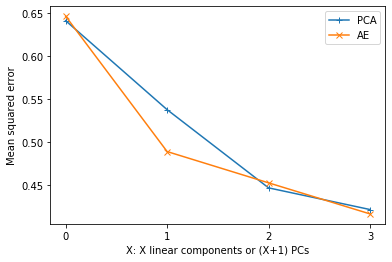

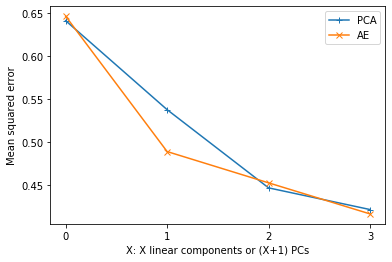

In [5]:
model.show_elbow()

## Training

In [6]:
import cyclum.models

model = cyclum.models.AutoEncoder(input_width=Y.shape[1],
                                  encoder_width=[30, 20], 
                                  encoder_depth=2,
                                 n_circular_unit=2,
                                 n_logistic_unit=0,
                                 n_linear_unit=0,
                                 n_linear_bypass=3,
                                 dropout_rate=0.1)
model.train(Y, epochs=1000, verbose=100, rate=2e-4)

epoch: 100/1000, loss:  0.4513, time elapsed:  5.25s, time left:  47.22s
epoch: 200/1000, loss:  0.4296, time elapsed:  9.99s, time left:  39.97s
epoch: 300/1000, loss:  0.4224, time elapsed:  14.73s, time left:  34.37s
epoch: 400/1000, loss:  0.4205, time elapsed:  19.46s, time left:  29.20s
epoch: 500/1000, loss:  0.4185, time elapsed:  24.30s, time left:  24.30s
epoch: 600/1000, loss:  0.4174, time elapsed:  29.01s, time left:  19.34s
epoch: 700/1000, loss:  0.4184, time elapsed:  33.76s, time left:  14.47s
epoch: 800/1000, loss:  0.4174, time elapsed:  38.29s, time left:  9.57s
epoch: 900/1000, loss:  0.4165, time elapsed:  43.25s, time left:  4.81s
epoch: 1000/1000, loss:  0.4168, time elapsed:  48.28s, time left:  0.00s


In [7]:
#model.train(Y, epochs=1000, verbose=100, rate=5e-5)

In [8]:
pseudotime = model.predict_pseudotime(Y)


## Illustration and Evaluation

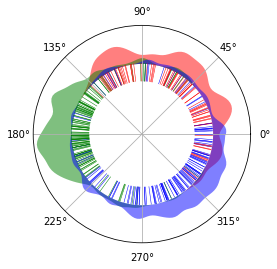

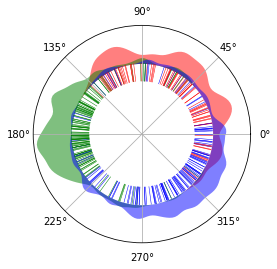

In [9]:
import cyclum.illustration
color_map = {"g0/g1": "red", "s": "green", "g2/m": "blue"}
cyclum.illustration.plot_round_distr_color(pseudotime[:, 0], cpt.squeeze(), color_map)

(0, 3.141592653589793)

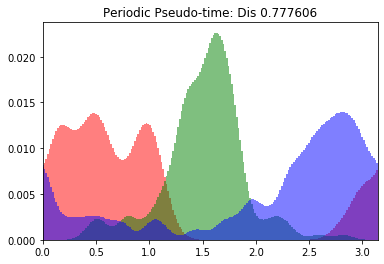

In [10]:
flat_embedding = (pseudotime % (2 * np.pi)) / 2
import cyclum.evaluation

width = 3.14 / 100 / 2;

discrete_time, distr_g0g1 = cyclum.evaluation.periodic_parzen_estimate(flat_embedding[np.squeeze(cpt)=='g0/g1', 0])
plt.bar(discrete_time, distr_g0g1, color='red', alpha=0.5, width = width)

discrete_time, distr_s = cyclum.evaluation.periodic_parzen_estimate(flat_embedding[np.squeeze(cpt)=='s', 0])
plt.bar(discrete_time, distr_s, color='green', alpha=0.5, width = width)

discrete_time, distr_g2m = cyclum.evaluation.periodic_parzen_estimate(flat_embedding[np.squeeze(cpt)=='g2/m', 0])
plt.bar(discrete_time, distr_g2m, color='blue', alpha=0.5, width = width)

correct_prob = cyclum.evaluation.precision_estimate([distr_g0g1, distr_s, distr_g2m], cpt, ['g0/g1', 's', 'g2/m'])
dis_score = correct_prob
plt.title("Periodic Pseudo-time: Dis %f" % dis_score)
plt.xlim([0, np.pi])

Note that this metric, although similar, is not exactly the same as the one we reported using mclust in R.

We use a non-parametric parzen window method to estimate the distribution here, 
while mclust uses a parametric normal mixture.

## Saving Results for Downstream Analysis in R

In [11]:
from cyclum.hdfrw import mat2hdf

mat2hdf(pseudotime, '../../data/McDavid/pc3-pseudotime.h5')

In [12]:
layer = model.model.get_layer('decoder_out')
weights = layer.get_weights()[0]
mat2hdf(weights, "../../data/McDavid/pc3-weight.h5")
